In [1]:
from __future__ import division
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from timeit import default_timer
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
import random
import argparse
from tqdm import tqdm
import librosa
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from torchsummary import summary
from scipy.stats import mode
from sklearn.model_selection import KFold
from torchvision.models import densenet121
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import recall_score


os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [2]:
EPOCHS = 20
SEED = 2024
BATCH_SIZE = 32
TEST_SPLIT_RATIO = 0.25
AUGM = False # Augmentation
# Creating the results directory
if not os.path.exists('results'):
    os.makedirs('results')
RESULTS_FILENAME = "./results/inrun_results" # _x.csv
VALID_RESULTS_FILENAME = "./results/valid_results" # _x.csv
TRAIN_RESULTS_FILENAME = "./results/train_results" # _x.csv
BEST_MODEL_FILENAME = "./results/best-model" # _x.pt
EVAL_FREQ=4
NUM_SIMS = 5

In [3]:
TRAIN_DATASET = "../data/train_whales.csv"
TEST_DATASET = "../data/test_whales.csv"

In [4]:
# Fixing the seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"Cuda is available: {torch.cuda.is_available()}")
dev_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print(f"Device: {dev_names}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda is available: True
Device: ['NVIDIA GeForce RTX 3090']


In [5]:
target_names = ["no-whale","whale"]
target_names_dict = {target_names[i]: i for i in range(len(target_names))}

# Loading the data

In [6]:
t_s = default_timer()
data_train = pd.read_csv(TRAIN_DATASET,sep=",")
columns = data_train.columns
data_train[columns[-1]]=data_train[columns[-1]].replace(target_names_dict)
data_train = data_train.values
data_train_labels = data_train[:,-1].reshape(-1)
data_train_labels = data_train_labels.astype(int)
data_train = data_train[:,:-1]

data_test = pd.read_csv(TEST_DATASET,sep=",")
data_test[columns[-1]]=data_test[columns[-1]].replace(target_names_dict)
data_test = data_test.values
data_test_labels = data_test[:,-1].reshape(-1)
data_test_labels = data_test_labels.astype(int)
data_test = data_test[:,:-1]
t_e = default_timer()

print(f"Data loading - Elapsed time: {t_e-t_s:.2f}s")

Data loading - Elapsed time: 8.83s


In [7]:
X_test, y_test = data_test, data_test_labels

In [8]:
data_train.shape, data_test.shape

((10316, 4000), (2580, 4000))

In [9]:
def random_data_shift(data, u=1.0):
    if np.random.random() < u:
        shift = int(round(np.random.uniform(-len(data)*0.25, len(data)*0.25)))
        data = np.roll(data, shift)
    return data

class AugmentedDataset(Dataset):
    def __init__(self, inputs, targets, augment=False):
        self.inputs = inputs
        self.targets = targets
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        sample = self.inputs[idx]
        if self.augment:
            sample = random_data_shift(sample)
            
        
        data = sample.copy()
        return torch.FloatTensor(data), torch.LongTensor([self.targets[idx]])

# Data loader
def create_dataloader(inputs, targets, batch_size, shuffle=True, augment=False):
    dataset = AugmentedDataset(inputs, targets, augment=augment)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Model

In [11]:
################################################################
#  1d spectral layer - FNO
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        ** Source : https://github.com/neural-operator/fourier_neural_operator **
        """
      
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, 2, dtype=torch.float))
        

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,device = x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], torch.view_as_complex(self.weights1))

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        
        return x

################################################################
#  1d Fourier layer
################################################################
class FourierLayer(nn.Module):
    """
    A Fourier Layer
    """

    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, modes):
        super(FourierLayer, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               padding=padding, stride=stride, bias=True)
        self.conv_fno1 = SpectralConv1d(in_channels,out_channels, modes)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv_fno1(x)
        out = x1 + x2
        
        return out
        
################################################################
#  Residual Block
################################################################
class ResidualBlock_FNO(nn.Module):
    """
    A residual block
    """

    def __init__(self, channels, kernel_size, padding, stride, modes):
        super(ResidualBlock_FNO, self).__init__()
                                   
        self.fn1 = FourierLayer(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=stride, padding=padding, modes = modes)
        self.fn2 = FourierLayer(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=stride, padding=padding, modes = modes)
        
        self.bn1 = nn.BatchNorm1d(num_features=channels)
        self.bn2 = nn.BatchNorm1d(num_features=channels)
        
    def forward(self, x):
        residual = x

        
        out = F.gelu(self.fn1(x))
        out = self.bn1(out)
        
        out = F.gelu(self.fn2(out))
        out = self.bn2(out)
        
        out = out + residual
        
        return out
    
################################################################
#  Residual Network - FNO
################################################################
class ResNet9_FNO_small(nn.Module):
    """
    A Residual network.
    """
    def __init__(self,pool_size=2,kernel_size=11,modes=16):
        super(ResNet9_FNO_small, self).__init__()
        
        self.pool_size = pool_size
        self.kernel_size = kernel_size
        
        self.conv1 = FourierLayer(in_channels=1, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        self.bn1 = nn.BatchNorm1d(num_features=32)
        
        self.conv2 = FourierLayer(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        
        self.rb1 = ResidualBlock_FNO(channels=64, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        
        self.conv3 = FourierLayer(in_channels=64, out_channels=96, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        self.bn3 = nn.BatchNorm1d(num_features=96)
        
        self.conv4 = FourierLayer(in_channels=96, out_channels=128, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        
        self.rb2 = ResidualBlock_FNO(channels=128, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes=modes)

        self.gap = torch.nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Linear(in_features=128, out_features = 1, bias=True)

    def forward(self, x):
        x = x[:,None,:]
        batch_size = len(x)
        
        
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = F.gelu(x)
        x = self.bn2(x)
        
        ##################
        # 1st residual
        ##################
        
        x = F.avg_pool1d(x,kernel_size=self.pool_size,stride=self.pool_size)
        x = self.rb1(x)
        
        x = self.conv3(x)
        x = F.gelu(x)
        x = self.bn3(x)
        
        x = F.avg_pool1d(x,kernel_size=self.pool_size,stride=self.pool_size)
        
        x = self.conv4(x)
        x = F.gelu(x)
        x = self.bn4(x)
        
        ##################
        # 2nd residual
        ##################
        
        x = F.avg_pool1d(x,kernel_size=self.pool_size,stride=self.pool_size)
        x = self.rb2(x)
                
        x = self.gap(x)
        x = x.view(batch_size,-1)
        
        
        out = self.fc(x)
        
        return out

# Utilities

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()
    number_of_elements = 0
    
    correct_pred = torch.zeros(2)
    total_pred = torch.zeros(2)


    with torch.no_grad():
        
        y_true = []
        y_pred = []
        for x, y in iterator:

            x = x.to(device)
            y = y.float().to(device).view(-1,1)
            
            batch_size = x.shape[0]
            number_of_elements += batch_size
            
            pred = model(x).view(-1,1)
            loss = criterion(pred, y)
            
            top_pred = (torch.sigmoid(pred) > 0.5).int()
            acc = top_pred.eq(y.int().view_as(top_pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            y_true.append(y.int().cpu().numpy())
            y_pred.append(top_pred.cpu().numpy())
            
        y_true_a = np.concatenate(y_true, axis=0)
        y_pred_a = np.concatenate(y_pred, axis=0)
                        
        #balanced_acc = balanced_accuracy_score(y_true_a, y_pred_a)
        acc = accuracy_score(y_true_a, y_pred_a)

    return epoch_loss / number_of_elements, acc

# Evaluation of the metamodels & finding the best one

In [14]:
valid_accs = {0:0.0,
              1:0.0,
              2:0.0,
              3:0.0,
              4:0.0}

valid_ind = {0:0,
              1:0,
              2:0,
              3:0,
              4:0}


for split_id in range(5): # split
    for model_num in range(5): # simulation
        df_valid = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{split_id}_{model_num}.csv",sep=";")
        if valid_accs[split_id] < df_valid["valid_acc"].max():
            valid_accs[split_id] = df_valid["valid_acc"].max()
            valid_ind[split_id] = model_num

In [15]:
valid_ind

{0: 0, 1: 2, 2: 2, 3: 0, 4: 1}

In [16]:
valid_accs

{0: 92.24806201550388,
 1: 91.66262724188076,
 2: 91.71110033931168,
 3: 91.66262724188076,
 4: 91.22636936500244}

# Evaluation of the best metamodel

In [17]:
criterion = torch.nn.BCEWithLogitsLoss(reduction="sum").to(device)


In [18]:
fold_results = np.zeros((len(data_test_labels), 5))  # 5 model predikciójának tárolására
fold_results_probs = np.zeros((len(data_test_labels), 5),dtype=float)  # 5 model predikciójának tárolására
for split_id, (train_index, valid_index) in enumerate(kf.split(data_train)):
    
    X_train, X_valid = data_train[train_index], data_train[valid_index]
    y_train, y_valid = data_train_labels[train_index], data_train_labels[valid_index]
    X_test, y_test = data_test, data_test_labels
    
    
    
    train_loader = create_dataloader(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True, augment=AUGM)
    valid_loader = create_dataloader(X_valid, y_valid, batch_size=BATCH_SIZE, shuffle=False, augment=False)
    test_loader = create_dataloader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False, augment=False)
    
    EVAL_FREQ_ = len(train_loader)//EVAL_FREQ + 1
    
    model = ResNet9_FNO_small()
    state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{split_id}_{valid_ind[split_id]}.pt")
    model.load_state_dict(state_dict)
    model.to(device)
    train_loss, train_acc = evaluate(model, train_loader, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    print(f'Split {split_id} - model {valid_ind[split_id]} | Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t')
    
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            output = model(data.to(device))
            probs = torch.sigmoid(output)
            preds =  (probs > 0.5).int().cpu().numpy()
            
            probs = probs.cpu().numpy()
            fold_results[i*BATCH_SIZE:i*BATCH_SIZE+len(preds), split_id] = preds.reshape(-1)
            fold_results_probs[i*BATCH_SIZE:i*BATCH_SIZE+len(preds), split_id] = probs.reshape(-1)
            

Split 0 - model 0 | Train Loss: 0.149 -  Train Acc: 94.15% | Valid Loss: 0.213 - Valid Acc: 92.25% | Test Loss: 0.238 - Test Acc: 90.66% 	
Split 1 - model 2 | Train Loss: 0.119 -  Train Acc: 95.60% | Valid Loss: 0.211 - Valid Acc: 91.66% | Test Loss: 0.217 - Test Acc: 91.28% 	
Split 2 - model 2 | Train Loss: 0.154 -  Train Acc: 93.86% | Valid Loss: 0.253 - Valid Acc: 91.71% | Test Loss: 0.243 - Test Acc: 90.85% 	
Split 3 - model 0 | Train Loss: 0.122 -  Train Acc: 95.37% | Valid Loss: 0.224 - Valid Acc: 91.66% | Test Loss: 0.226 - Test Acc: 90.78% 	
Split 4 - model 1 | Train Loss: 0.080 -  Train Acc: 97.77% | Valid Loss: 0.234 - Valid Acc: 91.23% | Test Loss: 0.243 - Test Acc: 90.66% 	


In [19]:
fold_results

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.]])

In [20]:
final_predictions_test = mode(fold_results, axis=1)[0].flatten()
final_predictions_test_2 = np.round(np.mean(fold_results_probs, axis=1))

In [21]:
accuracy = np.mean(final_predictions_test == data_test_labels)
accuracy_2 = np.mean(final_predictions_test_2 == data_test_labels)
print(f'Test accuracy with majority voting: {accuracy*100:.2f}%')
print(f'Test accuracy with average voting: {accuracy_2*100:.2f}%')

Test accuracy with majority voting: 91.12%
Test accuracy with average voting: 91.16%


In [22]:
print(f"Test recall with majority voting: {recall_score(data_test_labels,final_predictions_test)*100:.2f}")
print(f"Test recall with average voting: {recall_score(data_test_labels,final_predictions_test_2)*100:.2f}")

Test recall with majority voting: 87.44
Test recall with average voting: 87.44


## Majority voting

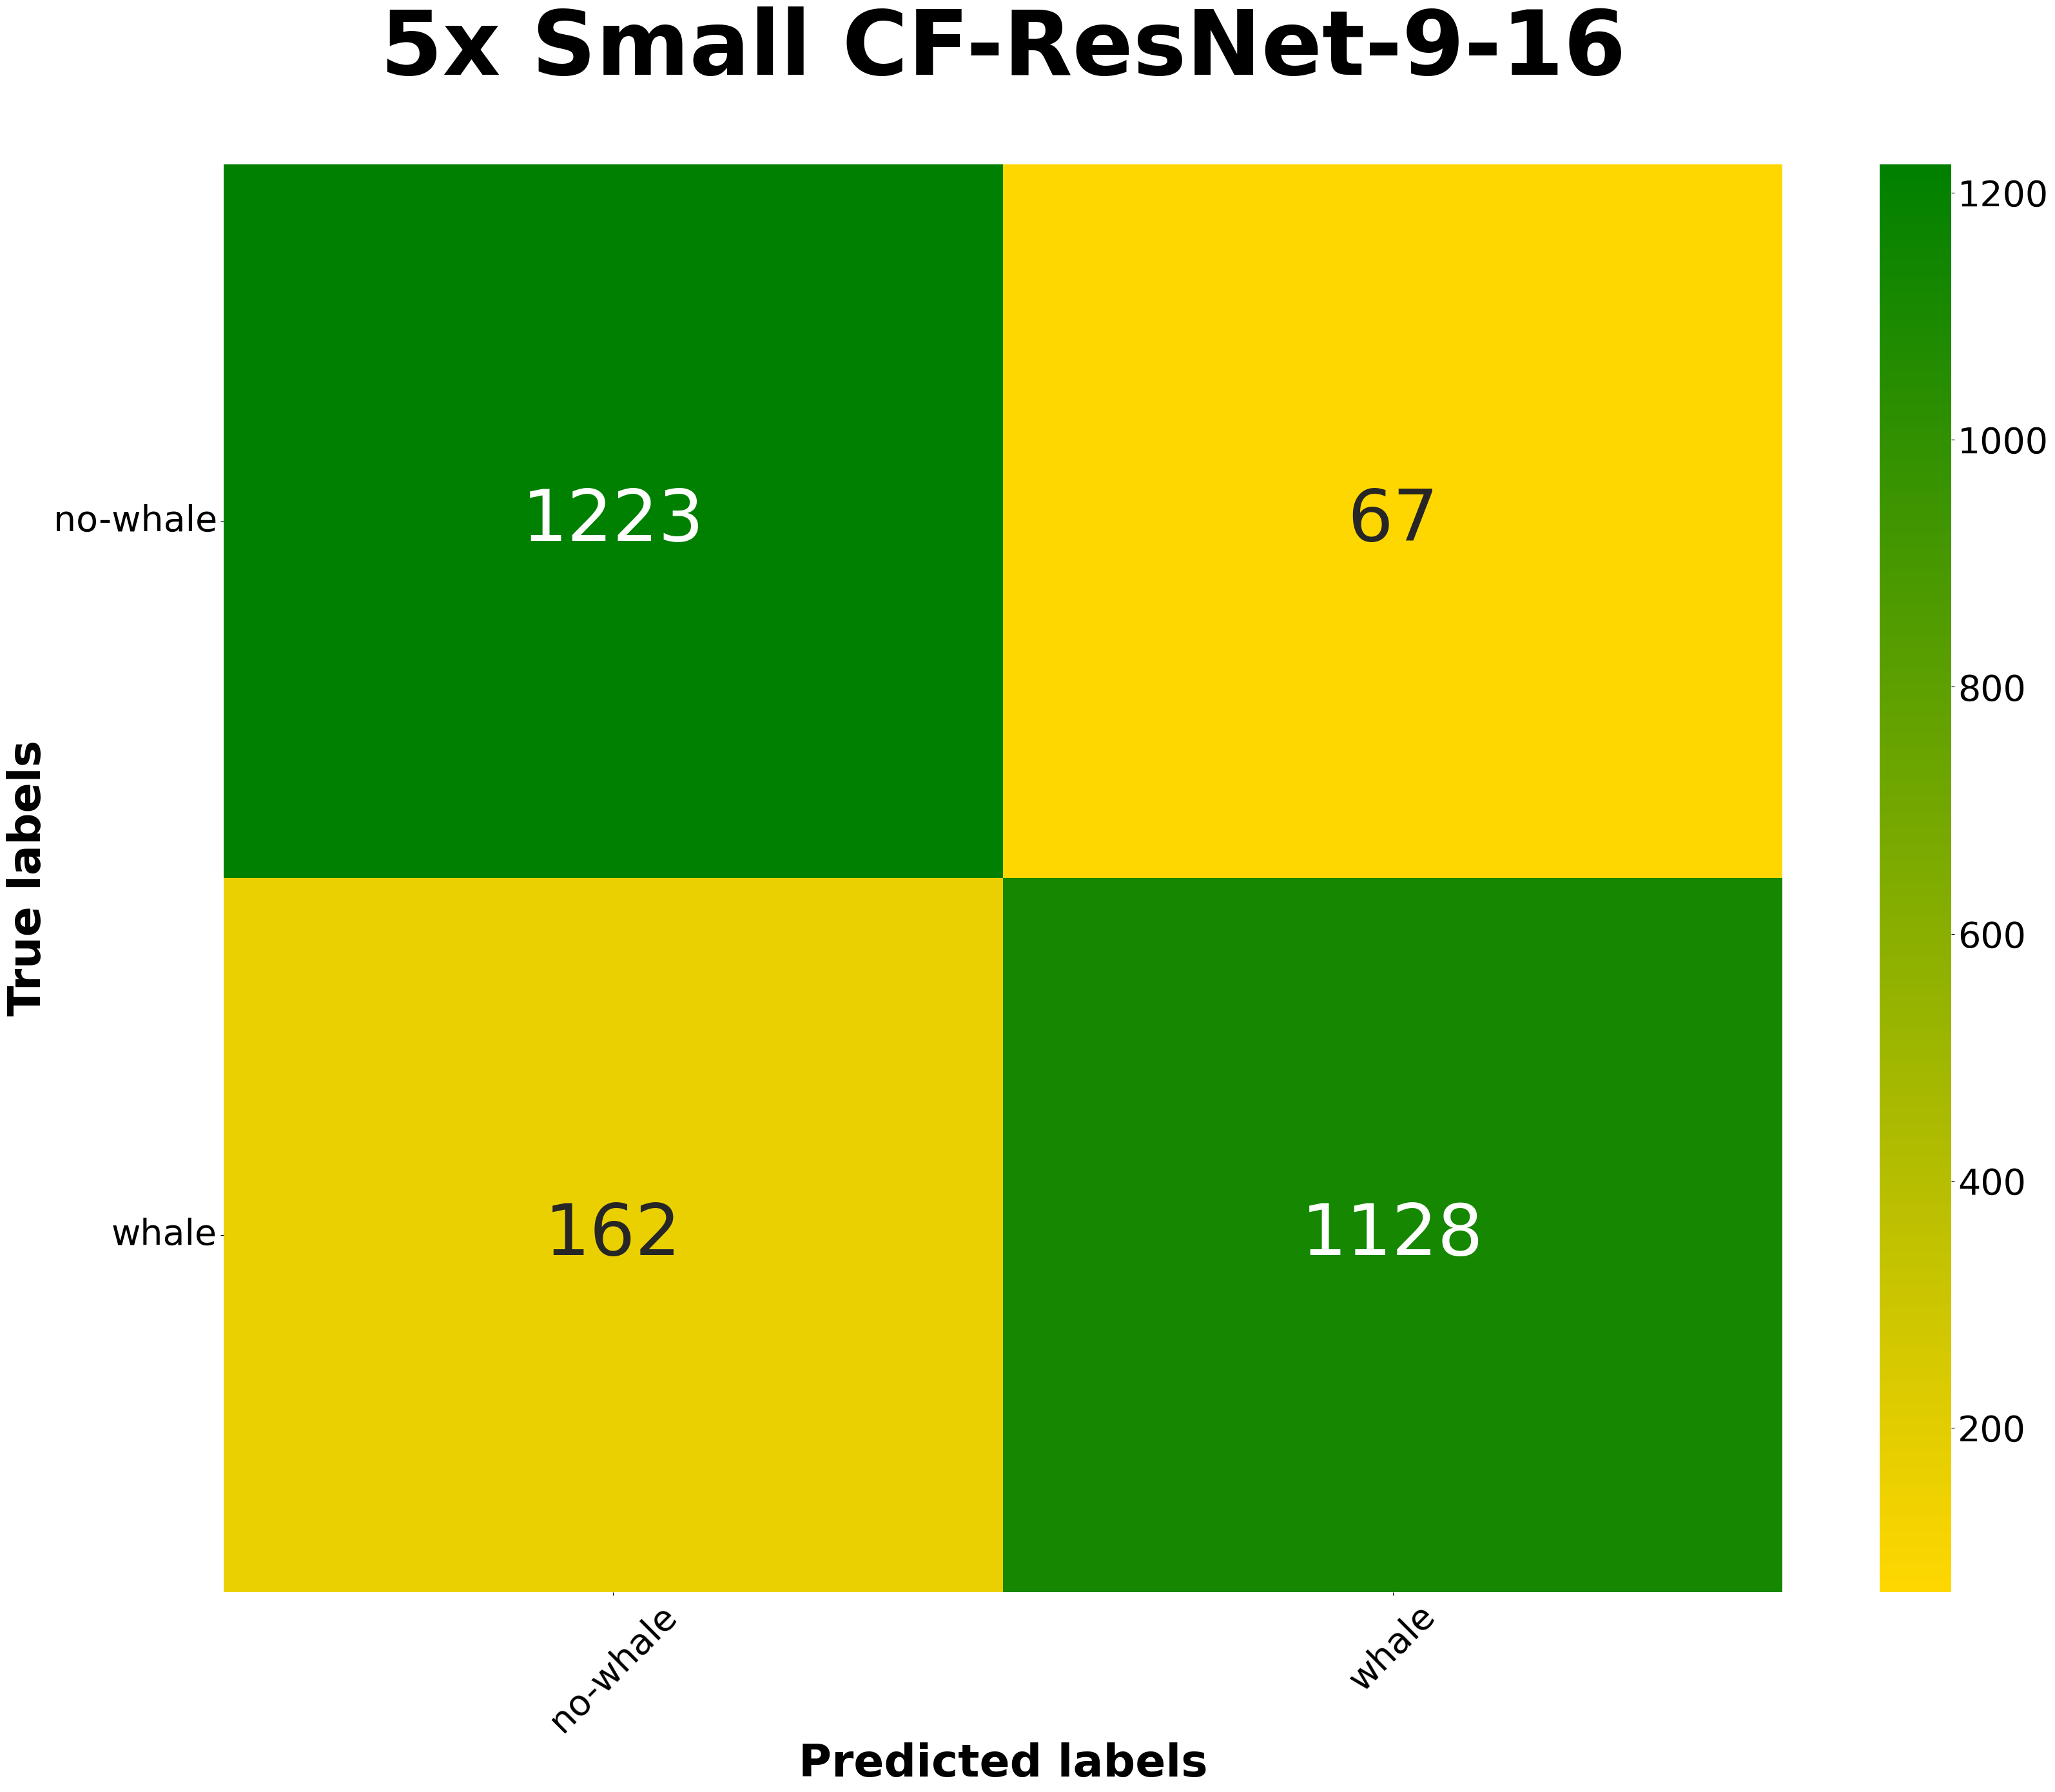

In [23]:
cm = confusion_matrix(data_test_labels, final_predictions_test, labels=list(range(len(target_names))))

SMALL_SIZE = 80
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize
plt.rc('figure', titlesize=0)  # fontsize of the figure title

# Create a custom colormap from gold to green
gold_green_cmap = LinearSegmentedColormap.from_list("gold_green", ["gold", "green"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(36,30))
sns.heatmap(cm, annot=True, fmt='g', cmap=gold_green_cmap, ax=ax)  # Use the custom colormap

# Set axis labels and titles with bold weight and adjusted fontsize
ax.set_xlabel('Predicted labels', weight="bold", fontsize=50)
ax.set_ylabel('True labels', weight="bold", fontsize=50)
tick_marks_x = np.arange(len(target_names)) + 0.5
tick_marks_y = np.arange(len(target_names)) + 0.5

# Set tick labels
plt.xticks(tick_marks_x, target_names, rotation=45, fontsize=40)
plt.yticks(tick_marks_y, target_names, rotation=0, fontsize=40)

# Set plot title
plt.title(f"5x Small CF-ResNet-9-16",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure

# Display the plot
plt.show()

# Save the figure
fig.savefig('cm_majority.svg', format='svg')

## Average voting

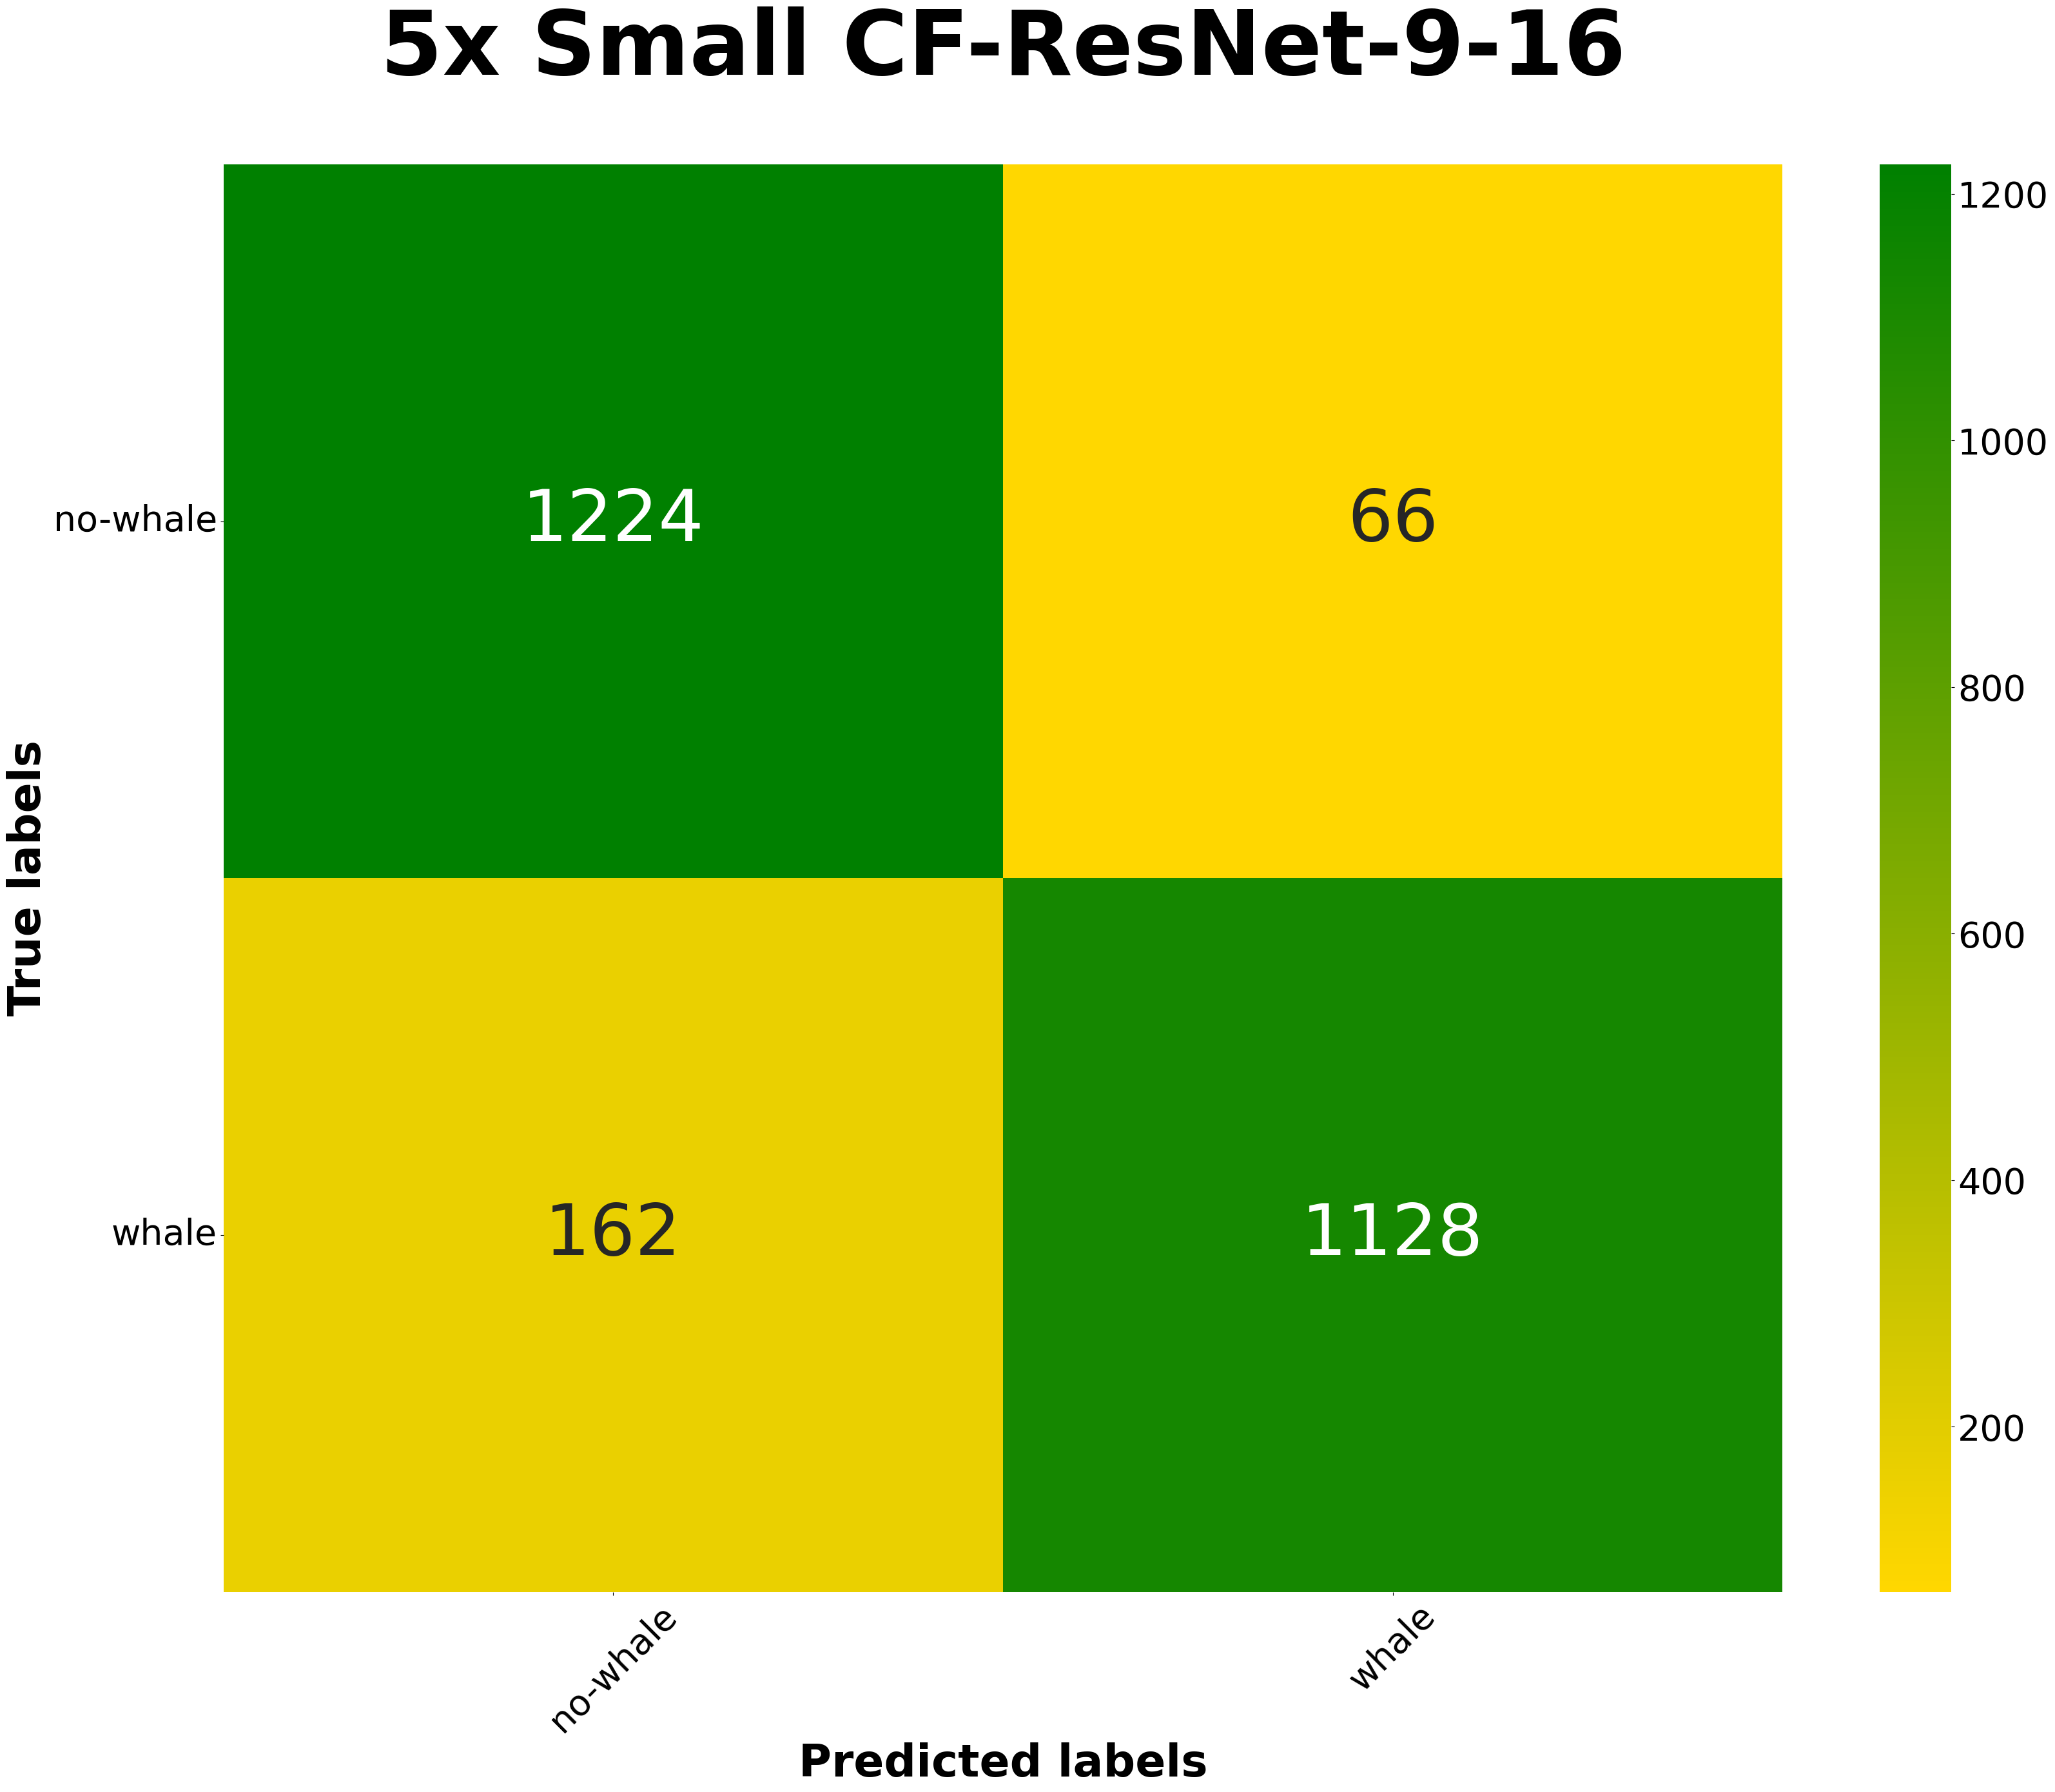

In [24]:
cm = confusion_matrix(data_test_labels, final_predictions_test_2, labels=list(range(len(target_names))))

SMALL_SIZE = 80
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize
plt.rc('figure', titlesize=0)  # fontsize of the figure title

# Create a custom colormap from gold to green
gold_green_cmap = LinearSegmentedColormap.from_list("gold_green", ["gold", "green"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(36,30))
sns.heatmap(cm, annot=True, fmt='g', cmap=gold_green_cmap, ax=ax)  # Use the custom colormap

# Set axis labels and titles with bold weight and adjusted fontsize
ax.set_xlabel('Predicted labels', weight="bold", fontsize=50)
ax.set_ylabel('True labels', weight="bold", fontsize=50)
tick_marks_x = np.arange(len(target_names)) + 0.5
tick_marks_y = np.arange(len(target_names)) + 0.5

# Set tick labels
plt.xticks(tick_marks_x, target_names, rotation=45, fontsize=40)
plt.yticks(tick_marks_y, target_names, rotation=0, fontsize=40)

# Set plot title
plt.title(f"5x Small CF-ResNet-9-16",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure

# Display the plot
plt.show()

# Save the figure
fig.savefig('cm_average.svg', format='svg')